# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [23]:
# Imports here
import matplotlib.pyplot as plt
import numpy as np
import torch,torchvision
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.models as models
from PIL import Image
import json
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns


## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). You can [download the data here](https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip). The dataset is split into two parts, training and validation. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. If you use a pre-trained network, you'll also need to make sure the input data is resized to 224x224 pixels as required by the networks.

The validation set is used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks available from `torchvision` were trained on the ImageNet dataset where each color channel was normalized separately. For both sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.

In [2]:
data_dir = 'flower_data'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'

In [3]:
# TODO: Define your transforms for the training and validation sets
data_transforms = transforms.Compose([transforms.RandomRotation(20),
                                       transforms.Resize(225),
                                       transforms.CenterCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ColorJitter(hue=.05, saturation=.05,brightness=.05),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])
test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

num_workers=0
batch_size=32
valid_size=0.2

train_data=datasets.ImageFolder('flower_data/train',transform=data_transforms)
test_data=datasets.ImageFolder('flower_data/valid',transform=data_transforms)

num_train=len(train_data)
train_list=[i for i in range(num_train)]
split=train_list[int(valid_size*num_train)]
np.random.shuffle(train_list)
train_idx,valid_idx=train_list[split:],train_list[:split]

train_sampler=SubsetRandomSampler(train_idx)
valid_sampler=SubsetRandomSampler(valid_idx)


# TODO: Load the datasets with ImageFolder
train_data = datasets.ImageFolder(train_dir, transform=data_transforms)
test_data = datasets.ImageFolder(valid_dir, transform=test_transforms)

# TODO: Using the image datasets and the trainforms, define the dataloaders
#dataloaders = 
trainloader = torch.utils.data.DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
testloader = torch.utils.data.DataLoader(test_data,shuffle=True, batch_size=batch_size)

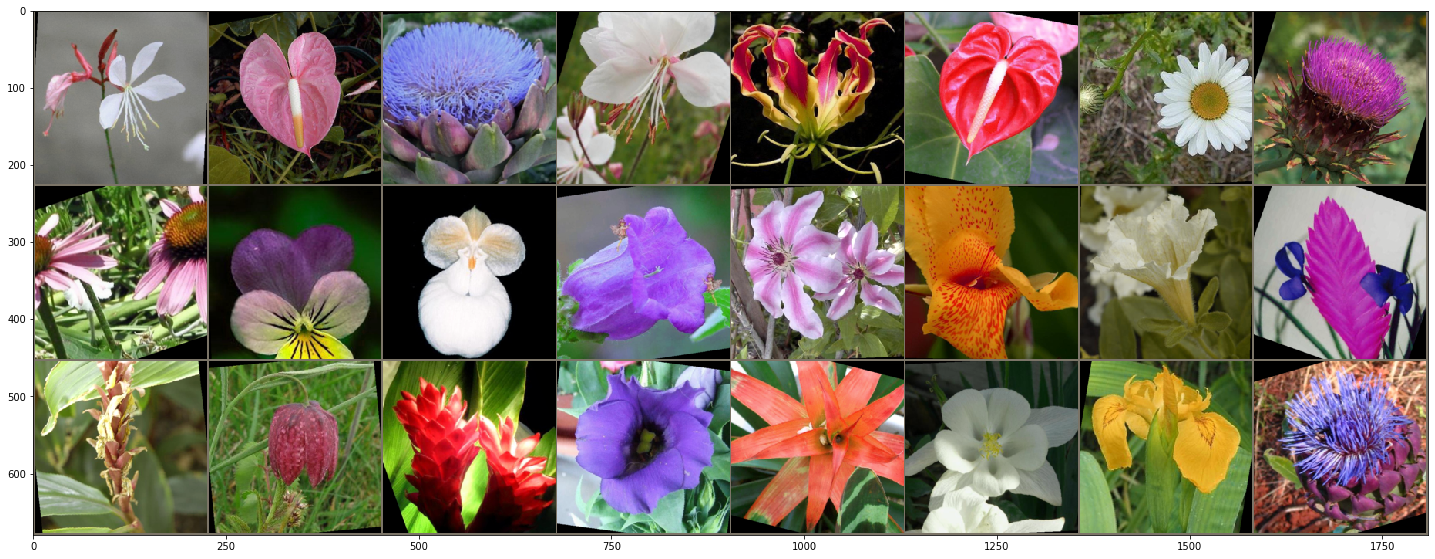

In [4]:
def imshow(img):
  plt.figure(figsize=(25,15))
  img=img.numpy()
  img[0,:,:]=img[0,:,:]*0.229+0.485
  img[1,:,:]=img[1,:,:]*0.224+0.456
  img[2,:,:]=img[2,:,:]*0.224+0.406
  plt.imshow(np.transpose(img,(1,2,0)))

images,labels=next(iter(trainloader))

img=torchvision.utils.make_grid(images[:24])
imshow(img)

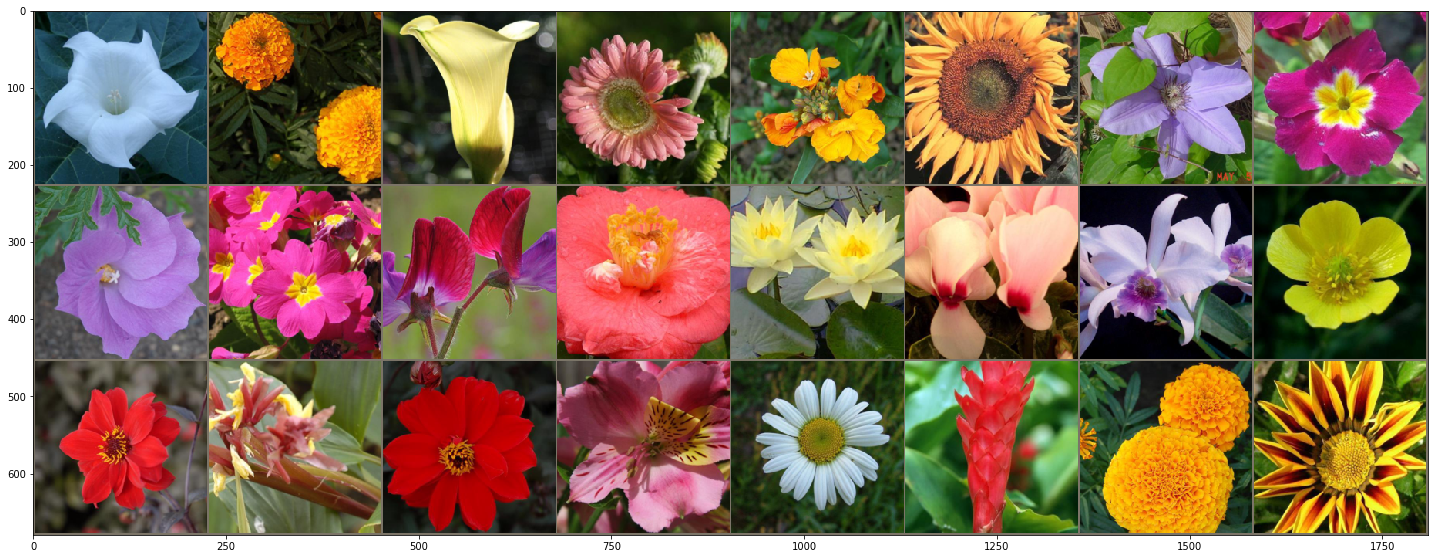

In [5]:
images,labels=next(iter(testloader))

img=torchvision.utils.make_grid(images[:24])
imshow(img)

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [6]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! You can also ask questions on the forums or join the instructors in office hours.

Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

In [7]:
model = models.resnet152(pretrained=True)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [8]:
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(2048, 1536)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(1536, 1024)),
                          ('relu', nn.ReLU()),
                          ('fc3', nn.Linear(1024, 512)),
                          ('relu', nn.ReLU()),
                          ('fc4', nn.Linear(512, 102)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    
model.classifier = classifier

In [9]:
import torch
import numpy as np


# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is not available.  Training on CPU ...


In [10]:
device=torch.device(("cuda") if torch.cuda.is_available() else "cpu")

In [11]:
# TODO: Build and train your network

lr=0.001
#Turn off gradients for our model
for param in model.parameters():
    param.requires_grad=False
    
#Define our new clasifier
classifier =nn.Sequential(nn.Linear(2048,512),
                    nn.ReLU(),
                    nn.Dropout(p=0.02),
                    nn.Linear(512,102),
                    nn.LogSoftmax(dim=1))
model.fc=classifier

criterion = nn.NLLLoss()

optimizer = optim.Adam(model.fc.parameters(), lr)


In [12]:
epochs=15
steps=0
running_loss= 0
print_every= 5
CUDA_LAUNCH_BLOCKING=1

valid_loss_min = np.Inf # track change in validation loss
valid_loss = 0.0

for epoch in range(epochs):
    epoch+=1
    for images, labels in trainloader:
        steps +=1
        
      
        optimizer.zero_grad()
        
        images, labels = images.to(device), labels.to(device)
        model.to(device);
        
        logps= model(images)
        loss = criterion (logps, labels)
        
        loss.backward()
    
        optimizer.step()
        
        running_loss +=loss.item()
        # update average validation loss 
        valid_loss += loss.item()*images.size(0)
        # calculate average losses
        valid_loss = valid_loss/len(trainloader.dataset)
        
        if steps % print_every==0:
            model.eval()
            test_loss = 0
            
            accuracy = 0
            
            for images, labels in testloader:
                
                images, labels = images.to(device), labels.to(device)
                logps = model(images)
                loss = criterion(logps, labels)
                
                test_loss+=loss.item()
                

                
                #calculate our accuracy
                ps= torch.exp(logps)
                top_ps, top_class = ps.topk(1, dim=1)
                equality = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equality.type(torch.FloatTensor))
                #scheduler.step(loss)

                       
                                       
            print(f"Epoch {epoch}/{epochs}/{steps}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
              # save model if validation loss has decreased
            if valid_loss <= valid_loss_min:
                print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                valid_loss_min,
                valid_loss))
                torch.save(model.state_dict(), 'checkpoint.pt')
                valid_loss_min = valid_loss
        
        running_loss = 0
        model.train()

Epoch 5/15/5.. Train loss: 0.950.. Test loss: 4.711.. Test accuracy: 0.030
Validation loss decreased (inf --> 0.023203).  Saving model ...
Epoch 10/15/10.. Train loss: 0.846.. Test loss: 4.398.. Test accuracy: 0.099
Validation loss decreased (0.023203 --> 0.020658).  Saving model ...
Epoch 15/15/15.. Train loss: 0.819.. Test loss: 4.272.. Test accuracy: 0.158
Validation loss decreased (0.020658 --> 0.020001).  Saving model ...
Epoch 20/15/20.. Train loss: 0.829.. Test loss: 4.129.. Test accuracy: 0.204
Epoch 25/15/25.. Train loss: 0.783.. Test loss: 3.974.. Test accuracy: 0.207
Validation loss decreased (0.020001 --> 0.019128).  Saving model ...
Epoch 30/15/30.. Train loss: 0.806.. Test loss: 3.805.. Test accuracy: 0.167
Epoch 35/15/35.. Train loss: 0.847.. Test loss: 3.684.. Test accuracy: 0.276
Epoch 40/15/40.. Train loss: 0.686.. Test loss: 3.534.. Test accuracy: 0.275
Validation loss decreased (0.019128 --> 0.016757).  Saving model ...
Epoch 45/15/45.. Train loss: 0.723.. Test loss

Epoch 74/15/400.. Train loss: 0.069.. Test loss: 0.527.. Test accuracy: 0.860
Validation loss decreased (0.001878 --> 0.001690).  Saving model ...
Epoch 79/15/405.. Train loss: 0.069.. Test loss: 0.526.. Test accuracy: 0.863
Validation loss decreased (0.001690 --> 0.001678).  Saving model ...
Epoch 84/15/410.. Train loss: 0.125.. Test loss: 0.530.. Test accuracy: 0.863
Epoch 89/15/415.. Train loss: 0.074.. Test loss: 0.510.. Test accuracy: 0.866
Epoch 94/15/420.. Train loss: 0.104.. Test loss: 0.490.. Test accuracy: 0.872
Epoch 99/15/425.. Train loss: 0.097.. Test loss: 0.508.. Test accuracy: 0.849
Epoch 104/15/430.. Train loss: 0.119.. Test loss: 0.485.. Test accuracy: 0.884
Epoch 109/15/435.. Train loss: 0.100.. Test loss: 0.464.. Test accuracy: 0.892
Epoch 114/15/440.. Train loss: 0.085.. Test loss: 0.484.. Test accuracy: 0.877
Epoch 119/15/445.. Train loss: 0.093.. Test loss: 0.460.. Test accuracy: 0.878
Epoch 124/15/450.. Train loss: 0.189.. Test loss: 0.548.. Test accuracy: 0.850

Epoch 65/15/880.. Train loss: 0.090.. Test loss: 0.381.. Test accuracy: 0.903
Epoch 70/15/885.. Train loss: 0.057.. Test loss: 0.375.. Test accuracy: 0.899
Epoch 75/15/890.. Train loss: 0.042.. Test loss: 0.340.. Test accuracy: 0.905
Epoch 80/15/895.. Train loss: 0.042.. Test loss: 0.316.. Test accuracy: 0.910
Epoch 85/15/900.. Train loss: 0.031.. Test loss: 0.396.. Test accuracy: 0.883
Epoch 90/15/905.. Train loss: 0.098.. Test loss: 0.433.. Test accuracy: 0.886
Epoch 95/15/910.. Train loss: 0.076.. Test loss: 0.396.. Test accuracy: 0.897
Epoch 100/15/915.. Train loss: 0.044.. Test loss: 0.365.. Test accuracy: 0.903
Epoch 105/15/920.. Train loss: 0.046.. Test loss: 0.330.. Test accuracy: 0.913
Epoch 110/15/925.. Train loss: 0.034.. Test loss: 0.328.. Test accuracy: 0.907
Epoch 115/15/930.. Train loss: 0.078.. Test loss: 0.339.. Test accuracy: 0.898
Epoch 120/15/935.. Train loss: 0.034.. Test loss: 0.334.. Test accuracy: 0.900
Epoch 125/15/940.. Train loss: 0.033.. Test loss: 0.296.. T

Epoch 86/15/1390.. Train loss: 0.062.. Test loss: 0.290.. Test accuracy: 0.913
Epoch 91/15/1395.. Train loss: 0.061.. Test loss: 0.291.. Test accuracy: 0.920
Epoch 96/15/1400.. Train loss: 0.028.. Test loss: 0.274.. Test accuracy: 0.927
Epoch 101/15/1405.. Train loss: 0.016.. Test loss: 0.286.. Test accuracy: 0.916
Epoch 106/15/1410.. Train loss: 0.052.. Test loss: 0.281.. Test accuracy: 0.919
Epoch 111/15/1415.. Train loss: 0.030.. Test loss: 0.276.. Test accuracy: 0.925
Epoch 116/15/1420.. Train loss: 0.028.. Test loss: 0.319.. Test accuracy: 0.919
Epoch 121/15/1425.. Train loss: 0.043.. Test loss: 0.322.. Test accuracy: 0.915
Epoch 126/15/1430.. Train loss: 0.045.. Test loss: 0.283.. Test accuracy: 0.923
Epoch 131/15/1435.. Train loss: 0.040.. Test loss: 0.263.. Test accuracy: 0.935
Epoch 136/15/1440.. Train loss: 0.037.. Test loss: 0.281.. Test accuracy: 0.929
Epoch 141/15/1445.. Train loss: 0.029.. Test loss: 0.331.. Test accuracy: 0.915
Epoch 146/15/1450.. Train loss: 0.038.. Tes

Epoch 112/15/1905.. Train loss: 0.028.. Test loss: 0.308.. Test accuracy: 0.906
Epoch 117/15/1910.. Train loss: 0.051.. Test loss: 0.346.. Test accuracy: 0.909
Epoch 122/15/1915.. Train loss: 0.044.. Test loss: 0.326.. Test accuracy: 0.909
Epoch 127/15/1920.. Train loss: 0.013.. Test loss: 0.336.. Test accuracy: 0.912
Epoch 132/15/1925.. Train loss: 0.043.. Test loss: 0.333.. Test accuracy: 0.911
Epoch 137/15/1930.. Train loss: 0.026.. Test loss: 0.298.. Test accuracy: 0.931
Epoch 142/15/1935.. Train loss: 0.036.. Test loss: 0.300.. Test accuracy: 0.938
Epoch 147/15/1940.. Train loss: 0.011.. Test loss: 0.241.. Test accuracy: 0.943
Epoch 152/15/1945.. Train loss: 0.014.. Test loss: 0.245.. Test accuracy: 0.935
Epoch 157/15/1950.. Train loss: 0.010.. Test loss: 0.316.. Test accuracy: 0.905
Epoch 162/15/1955.. Train loss: 0.062.. Test loss: 0.341.. Test accuracy: 0.913
Epoch 167/15/1960.. Train loss: 0.041.. Test loss: 0.256.. Test accuracy: 0.938
Epoch 172/15/1965.. Train loss: 0.029.. 

Epoch 133/15/2415.. Train loss: 0.042.. Test loss: 0.280.. Test accuracy: 0.929
Epoch 138/15/2420.. Train loss: 0.023.. Test loss: 0.320.. Test accuracy: 0.921
Epoch 143/15/2425.. Train loss: 0.027.. Test loss: 0.346.. Test accuracy: 0.919
Epoch 148/15/2430.. Train loss: 0.025.. Test loss: 0.313.. Test accuracy: 0.928
Epoch 153/15/2435.. Train loss: 0.045.. Test loss: 0.320.. Test accuracy: 0.913
Epoch 158/15/2440.. Train loss: 0.034.. Test loss: 0.318.. Test accuracy: 0.912
Epoch 163/15/2445.. Train loss: 0.052.. Test loss: 0.339.. Test accuracy: 0.903
Epoch 168/15/2450.. Train loss: 0.096.. Test loss: 0.338.. Test accuracy: 0.910
Epoch 173/15/2455.. Train loss: 0.026.. Test loss: 0.287.. Test accuracy: 0.919
Epoch 178/15/2460.. Train loss: 0.006.. Test loss: 0.333.. Test accuracy: 0.909


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [12]:
import os
data_dir = './flower_data'
train_dir = os.path.join(data_dir, 'train')
valid_dir = os.path.join(data_dir, 'valid')

dirs = {'train': train_dir, 
        'valid': valid_dir}

In [13]:
data_transforms = data_transforms = {
    'train': transforms.Compose([
             transforms.RandomRotation(20),
             transforms.Resize(255),
             transforms.CenterCrop(224),
             transforms.RandomHorizontalFlip(),

             transforms.ColorJitter(hue=.05, saturation=.05,brightness=.05),
             transforms.ToTensor(),
             transforms.Normalize([0.485, 0.456, 0.406],
                                  [0.229, 0.224, 0.225])]),
    'valid': transforms.Compose([
            transforms.Resize(255),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])])
} 
image_datasets = {x: datasets.ImageFolder(dirs[x],   transform=data_transforms[x]) for x in ['train', 'valid']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32, shuffle=True) for x in ['train', 'valid']}
dataset_sizes = {x: len(image_datasets[x]) 
                              for x in ['train', 'valid']}
class_names = image_datasets['train'].classes
model.class_to_idx = image_datasets['train'].class_to_idx

In [14]:
torch.save({
            'arch':'resnet152',
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'validation_accuraccy': 'x',
            'epochs':'15',
            'class_to_idx': model.class_to_idx,
            'status': 'moving towards overfitting',
            'validation_loss': '0.089',
            'train_loss': '0.217',
            }, 'checkpoint.pth')

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [15]:
# TODO: Write a function that loads a checkpoint and rebuilds the model

checkpoint = torch.load('checkpoint.pth')
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [16]:
with torch.no_grad():
    model.eval()
    accuracy=0.0
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        log_ps = model(images)
        

        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))
        
    print("Validation Accuracy: {:.3f}".format(accuracy/len(testloader)))

Validation Accuracy: 0.007


In [17]:
cat_to_name={"21": "fire lily", "3": "canterbury bells", "45": "bolero deep blue", "1": "pink primrose", "34": "mexican aster", "27": "prince of wales feathers", "7": "moon orchid", "16": "globe-flower", "25": "grape hyacinth", "26": "corn poppy", "79": "toad lily", "39": "siam tulip", "24": "red ginger", "67": "spring crocus", "35": "alpine sea holly", "32": "garden phlox", "10": "globe thistle", "6": "tiger lily", "93": "ball moss", "33": "love in the mist", "9": "monkshood", "102": "blackberry lily", "14": "spear thistle", "19": "balloon flower", "100": "blanket flower", "13": "king protea", "49": "oxeye daisy", "15": "yellow iris", "61": "cautleya spicata", "31": "carnation", "64": "silverbush", "68": "bearded iris", "63": "black-eyed susan", "69": "windflower", "62": "japanese anemone", "20": "giant white arum lily", "38": "great masterwort", "4": "sweet pea", "86": "tree mallow", "101": "trumpet creeper", "42": "daffodil", "22": "pincushion flower", "2": "hard-leaved pocket orchid", "54": "sunflower", "66": "osteospermum", "70": "tree poppy", "85": "desert-rose", "99": "bromelia", "87": "magnolia", "5": "english marigold", "92": "bee balm", "28": "stemless gentian", "97": "mallow", "57": "gaura", "40": "lenten rose", "47": "marigold", "59": "orange dahlia", "48": "buttercup", "55": "pelargonium", "36": "ruby-lipped cattleya", "91": "hippeastrum", "29": "artichoke", "71": "gazania", "90": "canna lily", "18": "peruvian lily", "98": "mexican petunia", "8": "bird of paradise", "30": "sweet william", "17": "purple coneflower", "52": "wild pansy", "84": "columbine", "12": "colt's foot", "11": "snapdragon", "96": "camellia", "23": "fritillary", "50": "common dandelion", "44": "poinsettia", "53": "primula", "72": "azalea", "65": "californian poppy", "80": "anthurium", "76": "morning glory", "37": "cape flower", "56": "bishop of llandaff", "60": "pink-yellow dahlia", "82": "clematis", "58": "geranium", "75": "thorn apple", "41": "barbeton daisy", "95": "bougainvillea", "43": "sword lily", "83": "hibiscus", "78": "lotus lotus", "88": "cyclamen", "94": "foxglove", "81": "frangipani", "74": "rose", "89": "watercress", "73": "water lily", "46": "wallflower", "77": "passion flower", "51": "petunia"}

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [18]:
def process_image(image_path):
    ''' 
    Scales, crops, and normalizes a PIL image for a PyTorch       
    model, returns an Numpy array
    '''
    # Open the image
    from PIL import Image
    img = Image.open(image_path)
    # Resize
    if img.size[0] > img.size[1]:
        img.thumbnail((10000, 256))
    else:
        img.thumbnail((256, 10000))
    # Crop 
    left_margin = (img.width-224)/2
    bottom_margin = (img.height-224)/2
    right_margin = left_margin + 224
    top_margin = bottom_margin + 224
    img = img.crop((left_margin, bottom_margin, right_margin,   
                      top_margin))
    # Normalize
    img = np.array(img)/255
    mean = np.array([0.485, 0.456, 0.406]) #provided mean
    std = np.array([0.229, 0.224, 0.225]) #provided std
    img = (img - mean)/std
    
    # Move color channels to first dimension as expected by PyTorch
    img = img.transpose((2, 0, 1))
    
    return img

    
    # TODO: Process a PIL image for use in a PyTorch model

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [19]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

In [20]:
def plot_solution(image_path, model):
    # Set up plot
    plt.figure(figsize = (6,10))
    ax = plt.subplot(2,1,1)
    # Set up title
    flower_num = image_path.split('/')[2]
    title_ = cat_to_name[flower_num]
    # Plot flower
    img = process_image(image_path)
    imshow(img, ax, title = title_);
    # Make prediction
    probs, labs, flowers = predict(image_path, model) 
    # Plot bar chart
    plt.subplot(2,1,2)
    sns.barplot(x=probs, y=flowers, color=sns.color_palette()[0]);
    plt.show()

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the validation accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [21]:
# TODO: Display an image along with the top 5 classes

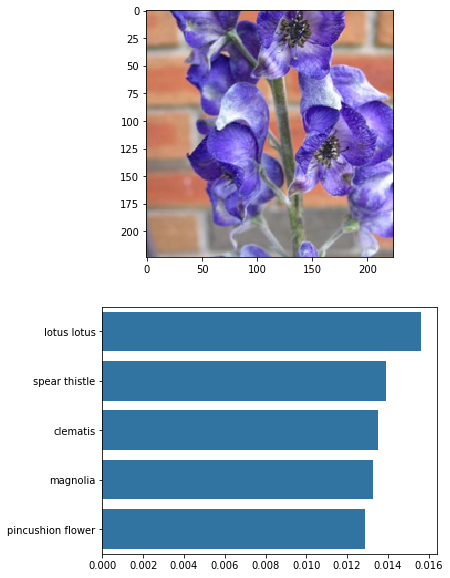

In [24]:

#def predict(image_path, model, topk=5):
''' Predict the class (or classes) of an image using a trained deep learning model.
'''
def predict(image_path, model, top_num=5):
    # Process image
    img = process_image(image_path)
    
    # Numpy -> Tensor
    image_tensor = torch.from_numpy(img).type(torch.FloatTensor)
    # Add batch of size 1 to image
    model_input = image_tensor.unsqueeze(0)
    
    image_tensor.to('cpu')
    model_input.to('cpu')
    model.to('cpu')
    
    # Probs
    probs = torch.exp(model.forward(model_input))
    
    # Top probs
    top_probs, top_labs = probs.topk(top_num)
    top_probs = top_probs.detach().numpy().tolist()[0] 
    top_labs = top_labs.detach().numpy().tolist()[0]
    
    # Convert indices to classes
    idx_to_class = {val: key for key, val in    
                                      model.class_to_idx.items()}
    top_labels = [idx_to_class[lab] for lab in top_labs]
    top_flowers = [cat_to_name[idx_to_class[lab]] for lab in top_labs]
    return top_probs, top_labels, top_flowers
    
    # TODO: Implement the code to predict the class from an image file
image_path='flower_data/valid/9/image_06414.jpg'
plot_solution(image_path, model)